In [1]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import sklearn
from sklearn import set_config


import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
set_config(transform_output = "pandas")

In [3]:
df = pd.read_csv(r'C:\Users\nilro\OneDrive\Escritorio\Capstone-Master-Data-Science\data_dsmarket\full_df.csv')

In [4]:
df.head()

,Unnamed: 0,id,date,item,category,department,store_code,region,store,sales_count,event_NewYear,event_None,event_SuperBowl,event_Thanksgiving,event_Ramadan,sell_price,revenue
0,0,ACCESORIES_1_001_NYC_1,2011-02-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,True,True,False,False,0.0,0.0
1,1,ACCESORIES_1_001_NYC_1,2011-02-13,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,True,False,False,False,0.0,0.0
2,2,ACCESORIES_1_001_NYC_1,2011-02-20,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,True,False,False,False,0.0,0.0
3,3,ACCESORIES_1_001_NYC_1,2011-02-27,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,True,False,False,False,0.0,0.0
4,4,ACCESORIES_1_001_NYC_1,2011-03-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,True,False,False,False,0.0,0.0


In [5]:
def load_data(path_data_file):
    '''
    Loads the csv file for training.
    '''
    df = pd.read_csv(path_data_file, index_col = 0)
    
    df = preprocess_df(df)
    
    return df

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323770 entries, 0 to 8323769
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   id                  object 
 2   date                object 
 3   item                object 
 4   category            object 
 5   department          object 
 6   store_code          object 
 7   region              object 
 8   store               object 
 9   sales_count         int64  
 10  event_NewYear       bool   
 11  event_None          bool   
 12  event_SuperBowl     bool   
 13  event_Thanksgiving  bool   
 14  event_Ramadan       bool   
 15  sell_price          float64
 16  revenue             float64
dtypes: bool(5), float64(2), int64(2), object(8)
memory usage: 801.8+ MB


In [7]:
df.drop(columns= 'Unnamed: 0', inplace = True)

In [8]:
df['id'].nunique()

30490

In [9]:
ORDER_COLUMNS = [
    'DATE',
    'ID',
    'ITEM',
    'ITEM_ID',
    'ITEM_CATEGORY',
    'ITEM_CATEGORY_ID',
    'ITEM_DEPARTMENT',
    'ITEM_DEPARTMENT_ID',
    'STORE_CODE',
    'REGION',
    'REGION_ID',
    'STORE',
    'STORE_ID',
    'SALES_COUNT',
    'SELL_PRICE',
    'REVENUE',
    'EVENT_NEWYEAR',
    'EVENT_NONE',
    'EVENT_SUPERBOWL',
    'EVENT_THANKSGIVING',
    'EVENT_RAMADAN',
    
    
    
    
]

In [10]:
def preprocess_df(df):
    df.columns = map(str.upper, df.columns)
    df['DATE'] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")
    
    df["CATEGORY_ID"] = OrdinalEncoder().fit_transform(df[["CATEGORY"]])
    df["DEPARTMENT_ID"] = OrdinalEncoder().fit_transform(df[["DEPARTMENT"]])
    df["REGION_ID"] = OrdinalEncoder().fit_transform(df[["REGION"]])
    df["STORE_ID"] = OrdinalEncoder().fit_transform(df[["STORE"]])
    df["ITEM_ID"] = OrdinalEncoder().fit_transform(df[["ITEM"]])
    
    df.rename(columns = {"CATEGORY":"ITEM_CATEGORY", "CATEGORY_ID":"ITEM_CATEGORY_ID", "DEPARTMENT":"ITEM_DEPARTMENT","DEPARTMENT_ID":"ITEM_DEPARTMENT_ID"}, inplace = True)
    df = df[ORDER_COLUMNS]
    
    return df


In [11]:
preprocess_df(df)

,DATE,ID,ITEM,ITEM_ID,ITEM_CATEGORY,ITEM_CATEGORY_ID,ITEM_DEPARTMENT,ITEM_DEPARTMENT_ID,STORE_CODE,REGION,...,STORE,STORE_ID,SALES_COUNT,SELL_PRICE,REVENUE,EVENT_NEWYEAR,EVENT_NONE,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN
0,2011-02-06,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,0.0,0.0,False,True,True,False,False
1,2011-02-13,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,0.0,0.0,False,True,False,False,False
2,2011-02-20,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,0.0,0.0,False,True,False,False,False
3,2011-02-27,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,0.0,0.0,False,True,False,False,False
4,2011-03-06,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,0.0,0.0,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8323765,2016-03-27,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,3048.0,SUPERMARKET,2.0,SUPERMARKET_3,6.0,PHI_3,Philadelphia,...,Queen_Village,5.0,17,1.2,20.4,False,True,False,False,False
8323766,2016-04-03,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,3048.0,SUPERMARKET,2.0,SUPERMARKET_3,6.0,PHI_3,Philadelphia,...,Queen_Village,5.0,22,1.2,26.4,False,True,False,False,False
8323767,2016-04-10,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,3048.0,SUPERMARKET,2.0,SUPERMARKET_3,6.0,PHI_3,Philadelphia,...,Queen_Village,5.0,8,1.2,9.6,False,True,False,False,False
8323768,2016-04-17,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,3048.0,SUPERMARKET,2.0,SUPERMARKET_3,6.0,PHI_3,Philadelphia,...,Queen_Village,5.0,0,1.2,0.0,False,True,False,False,False


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323770 entries, 0 to 8323769
Data columns (total 21 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ID                  object        
 1   DATE                datetime64[ns]
 2   ITEM                object        
 3   ITEM_CATEGORY       object        
 4   ITEM_DEPARTMENT     object        
 5   STORE_CODE          object        
 6   REGION              object        
 7   STORE               object        
 8   SALES_COUNT         int64         
 9   EVENT_NEWYEAR       bool          
 10  EVENT_NONE          bool          
 11  EVENT_SUPERBOWL     bool          
 12  EVENT_THANKSGIVING  bool          
 13  EVENT_RAMADAN       bool          
 14  SELL_PRICE          float64       
 15  REVENUE             float64       
 16  ITEM_CATEGORY_ID    float64       
 17  ITEM_DEPARTMENT_ID  float64       
 18  REGION_ID           float64       
 19  STORE_ID            float64       
 20  IT

In [13]:
df.head()

,ID,DATE,ITEM,ITEM_CATEGORY,ITEM_DEPARTMENT,STORE_CODE,REGION,STORE,SALES_COUNT,EVENT_NEWYEAR,...,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN,SELL_PRICE,REVENUE,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID,ITEM_ID
0,ACCESORIES_1_001_NYC_1,2011-02-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,True,False,False,0.0,0.0,0.0,0.0,1.0,2.0,0.0
1,ACCESORIES_1_001_NYC_1,2011-02-13,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,False,False,0.0,0.0,0.0,0.0,1.0,2.0,0.0
2,ACCESORIES_1_001_NYC_1,2011-02-20,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,False,False,0.0,0.0,0.0,0.0,1.0,2.0,0.0
3,ACCESORIES_1_001_NYC_1,2011-02-27,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,False,False,0.0,0.0,0.0,0.0,1.0,2.0,0.0
4,ACCESORIES_1_001_NYC_1,2011-03-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,False,False,0.0,0.0,0.0,0.0,1.0,2.0,0.0


In [14]:
df['DATE'].value_counts()

DATE
2011-02-06    30490
2014-07-20    30490
2014-08-31    30490
2014-08-24    30490
2014-08-17    30490
              ...  
2012-12-16    30490
2012-12-23    30490
2012-12-30    30490
2013-01-06    30490
2016-04-24    30490
Name: count, Length: 273, dtype: int64

In [15]:
df['ID'].value_counts()

ID
ACCESORIES_1_001_NYC_1       273
SUPERMARKET_2_202_BOS_3      273
SUPERMARKET_2_214_BOS_3      273
SUPERMARKET_2_213_BOS_3      273
SUPERMARKET_2_212_BOS_3      273
                            ... 
HOME_&_GARDEN_1_457_NYC_4    273
HOME_&_GARDEN_1_456_NYC_4    273
HOME_&_GARDEN_1_455_NYC_4    273
HOME_&_GARDEN_1_454_NYC_4    273
SUPERMARKET_3_827_PHI_3      273
Name: count, Length: 30490, dtype: int64

Por cada semana tenemos todos los productos

In [16]:
MIN_DATE = df["DATE"].min()
MAX_DATE = df["DATE"].max()

In [17]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2011-02-06 00:00:00
Max date is 2016-04-24 00:00:00


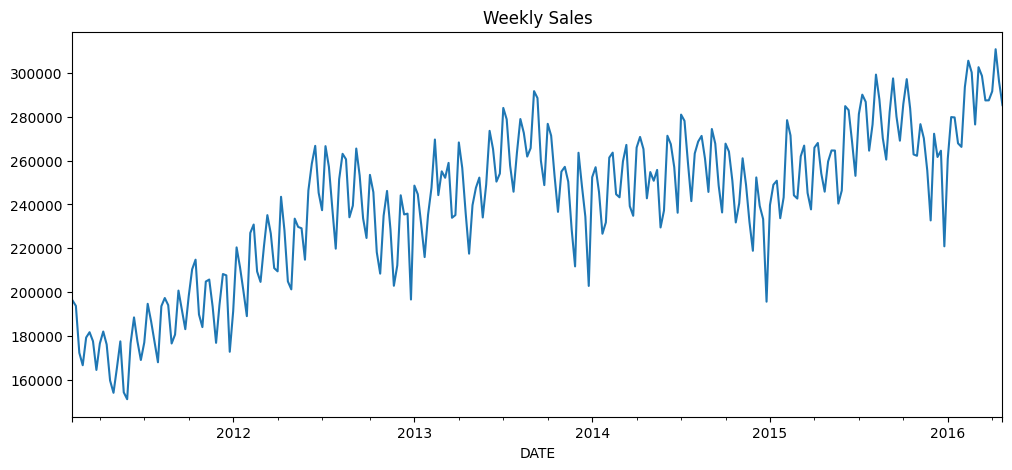

In [18]:
df.set_index("DATE").resample("W")["SALES_COUNT"].sum().plot(figsize = (12, 5), title = "Weekly Sales");

In [19]:
df["UNIQUE_DAYS_WITH_SALES"] = df["DATE"]
df["TOTAL_TRANSACTIONS"] = df["SALES_COUNT"]

In [20]:
df_monthly_agg = df.set_index("DATE").groupby(["ID"]).resample("W").agg(
    {
        "SALES_COUNT":np.sum,
        "REVENUE":np.sum,
        "UNIQUE_DAYS_WITH_SALES":lambda dates: len(set(dates)),
        "TOTAL_TRANSACTIONS":len,
        "SELL_PRICE":np.mean
    }
).rename(
    columns = {
        "SALES_COUNT":"WEEKLY_SALES",
        "REVENUE":"WEEKLY_REVENUE",
        "SELL_PRICE":"WEEKLY_MEAN_PRICE"
    }
).reset_index()

In [53]:
df_monthly_agg.head()

,ID,DATE,WEEKLY_SALES,WEEKLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,WEEKLY_MEAN_PRICE,CHECK
0,ACCESORIES_1_001_BOS_1,2011-02-06,0,0.0,1,1,0.0,True
1,ACCESORIES_1_001_BOS_1,2011-02-13,0,0.0,1,1,0.0,True
2,ACCESORIES_1_001_BOS_1,2011-02-20,0,0.0,1,1,0.0,True
3,ACCESORIES_1_001_BOS_1,2011-02-27,0,0.0,1,1,0.0,True
4,ACCESORIES_1_001_BOS_1,2011-03-06,0,0.0,1,1,0.0,True


In [54]:
df_monthly_agg[df_monthly_agg['DATE'] == '2011-10-09']

,ID,DATE,WEEKLY_SALES,WEEKLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,WEEKLY_MEAN_PRICE,CHECK
35,ACCESORIES_1_001_BOS_1,2011-10-09,0,0.0,1,1,0.0,True
308,ACCESORIES_1_001_BOS_2,2011-10-09,0,0.0,1,1,0.0,True
581,ACCESORIES_1_001_BOS_3,2011-10-09,0,0.0,1,1,0.0,True
854,ACCESORIES_1_001_NYC_1,2011-10-09,0,0.0,1,1,0.0,True
1127,ACCESORIES_1_001_NYC_2,2011-10-09,0,0.0,1,1,0.0,True
...,...,...,...,...,...,...,...,...
8322440,SUPERMARKET_3_827_NYC_3,2011-10-09,0,0.0,1,1,0.0,True
8322713,SUPERMARKET_3_827_NYC_4,2011-10-09,0,0.0,1,1,0.0,True
8322986,SUPERMARKET_3_827_PHI_1,2011-10-09,0,0.0,1,1,0.0,True
8323259,SUPERMARKET_3_827_PHI_2,2011-10-09,0,0.0,1,1,0.0,True


En cada fecha tenemos registrados TODOS los productos

In [55]:
df_monthly_agg[(df_monthly_agg['DATE'] == '2011-10-09') & (df_monthly_agg['WEEKLY_SALES'] > 0)]

,ID,DATE,WEEKLY_SALES,WEEKLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,WEEKLY_MEAN_PRICE,CHECK
2765,ACCESORIES_1_002_BOS_1,2011-10-09,1,5.2801,1,1,5.2801,True
3038,ACCESORIES_1_002_BOS_2,2011-10-09,1,5.2801,1,1,5.2801,True
3584,ACCESORIES_1_002_NYC_1,2011-10-09,2,10.5602,1,1,5.2801,True
3857,ACCESORIES_1_002_NYC_2,2011-10-09,1,5.2801,1,1,5.2801,True
4676,ACCESORIES_1_002_PHI_1,2011-10-09,2,10.5602,1,1,5.2801,True
...,...,...,...,...,...,...,...,...
8316707,SUPERMARKET_3_825_NYC_2,2011-10-09,2,9.5520,1,1,4.7760,True
8316980,SUPERMARKET_3_825_NYC_3,2011-10-09,5,26.2800,1,1,5.2560,True
8317253,SUPERMARKET_3_825_NYC_4,2011-10-09,9,47.3040,1,1,5.2560,True
8317526,SUPERMARKET_3_825_PHI_1,2011-10-09,2,10.5120,1,1,5.2560,True


In [56]:
df_monthly_agg["CHECK"] = df_monthly_agg["UNIQUE_DAYS_WITH_SALES"] == df_monthly_agg["TOTAL_TRANSACTIONS"]

In [57]:
df_monthly_agg[df_monthly_agg["CHECK"] == True].sample(5)

,ID,DATE,WEEKLY_SALES,WEEKLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,WEEKLY_MEAN_PRICE,CHECK
7548904,SUPERMARKET_3_541_BOS_2,2014-07-27,70,78.960,1,1,1.128,True
891132,ACCESORIES_1_335_NYC_2,2012-04-01,0,0.000,1,1,0.000,True
7605030,SUPERMARKET_3_561_PHI_1,2012-06-03,0,0.000,1,1,0.000,True
1608713,HOME_&_GARDEN_1_025_BOS_3,2014-11-16,1,3.725,1,1,3.725,True
6090465,SUPERMARKET_3_005_PHI_3,2013-03-03,18,42.768,1,1,2.376,True


Como tenemos todos los productos por todas las fechas, el check no nos permite ver los dias con mas de una venta por producto

In [58]:
check_months = df_monthly_agg.groupby("ID").size()
check_months.sample(3)

ID
HOME_&_GARDEN_1_076_NYC_3    273
ACCESORIES_1_087_NYC_1       273
SUPERMARKET_3_373_BOS_3      273
dtype: int64

In [59]:
check_months[check_months != 273].shape

(0,)

In [60]:
DATE_PREDICTION = np.datetime64("2016-05-31")
date_range = pd.date_range(MIN_DATE, DATE_PREDICTION, freq = "W")
date_range

DatetimeIndex(['2011-02-06', '2011-02-13', '2011-02-20', '2011-02-27',
               '2011-03-06', '2011-03-13', '2011-03-20', '2011-03-27',
               '2011-04-03', '2011-04-10',
               ...
               '2016-03-27', '2016-04-03', '2016-04-10', '2016-04-17',
               '2016-04-24', '2016-05-01', '2016-05-08', '2016-05-15',
               '2016-05-22', '2016-05-29'],
              dtype='datetime64[ns]', length=278, freq='W-SUN')

In [61]:
date_range.value_counts()

2011-02-06    1
2014-08-10    1
2014-09-21    1
2014-09-14    1
2014-09-07    1
             ..
2012-12-23    1
2012-12-30    1
2013-01-06    1
2013-01-13    1
2016-05-29    1
Name: count, Length: 278, dtype: int64

In [62]:
unique_id = sorted(df_monthly_agg["ID"].unique())
unique_id[:3]

['ACCESORIES_1_001_BOS_1', 'ACCESORIES_1_001_BOS_2', 'ACCESORIES_1_001_BOS_3']

In [63]:
len(unique_id)

30490

In [64]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["DATE", "ID"])
len(cartesian_product)

8476220

In [65]:
30490 * 278

8476220

In [66]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

print(full_df.shape)

full_df = pd.merge(full_df, df_monthly_agg, on = ['DATE','ID'], how = 'left')

print(full_df.shape)

(8476220, 2)
(8476220, 8)


In [67]:
full_df.sample(5)

,DATE,ID,WEEKLY_SALES,WEEKLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,WEEKLY_MEAN_PRICE,CHECK
7831020,2016-01-03,SUPERMARKET_3_334_BOS_1,0.0,0.0000,1.0,1.0,3.5760,True
8092838,2016-03-06,HOME_&_GARDEN_2_203_PHI_2,21.0,77.9625,1.0,1.0,3.7125,True
3169638,2013-01-27,SUPERMARKET_3_692_PHI_2,22.0,21.1200,1.0,1.0,0.9600,True
4741055,2014-01-26,HOME_&_GARDEN_2_415_NYC_3,0.0,0.0000,1.0,1.0,3.1000,True
7033831,2015-07-05,SUPERMARKET_2_287_BOS_2,5.0,15.0000,1.0,1.0,3.0000,True


In [68]:
add_info = df[
    ["ID", "ITEM", "ITEM_ID", "ITEM_CATEGORY", "ITEM_CATEGORY_ID", "ITEM_DEPARTMENT", "ITEM_DEPARTMENT_ID", "STORE_CODE",
     "REGION", "REGION_ID", "STORE", "STORE_ID"]
].drop_duplicates()

add_info.head(3)

,ID,ITEM,ITEM_ID,ITEM_CATEGORY,ITEM_CATEGORY_ID,ITEM_DEPARTMENT,ITEM_DEPARTMENT_ID,STORE_CODE,REGION,REGION_ID,STORE,STORE_ID
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,1.0,Greenwich_Village,2.0
273,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,1.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,1.0,Greenwich_Village,2.0
546,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,2.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,1.0,Greenwich_Village,2.0


In [69]:
add_info.shape

(30490, 12)

Si ponemos eventos da el numero correcto de unique ID, se crean columnas diferentes i extras debido a estos, asi que por ahora eliminamos eventos 
, "EVENT_NEWYEAR", "EVENT_NONE", "EVENT_SUPERBOWL", "EVENT_THANKSGIVING", "EVENT_RAMADAN"

In [70]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = add_info,
    how = "left",
    on = "ID"
)

print(full_df.shape)

(8476220, 8)
(8476220, 19)


In [71]:
full_df.drop(["CHECK"], axis = 1, inplace = True)

In [72]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8476220 entries, 0 to 8476219
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   DATE                    datetime64[ns]
 1   ID                      object        
 2   WEEKLY_SALES            float64       
 3   WEEKLY_REVENUE          float64       
 4   UNIQUE_DAYS_WITH_SALES  float64       
 5   TOTAL_TRANSACTIONS      float64       
 6   WEEKLY_MEAN_PRICE       float64       
 7   ITEM                    object        
 8   ITEM_ID                 float64       
 9   ITEM_CATEGORY           object        
 10  ITEM_CATEGORY_ID        float64       
 11  ITEM_DEPARTMENT         object        
 12  ITEM_DEPARTMENT_ID      float64       
 13  STORE_CODE              object        
 14  REGION                  object        
 15  REGION_ID               float64       
 16  STORE                   object        
 17  STORE_ID                float64       
dtypes:

In [73]:
full_df.isnull().sum()

DATE                           0
ID                             0
WEEKLY_SALES              152450
WEEKLY_REVENUE            152450
UNIQUE_DAYS_WITH_SALES    152450
TOTAL_TRANSACTIONS        152450
WEEKLY_MEAN_PRICE         152450
ITEM                           0
ITEM_ID                        0
ITEM_CATEGORY                  0
ITEM_CATEGORY_ID               0
ITEM_DEPARTMENT                0
ITEM_DEPARTMENT_ID             0
STORE_CODE                     0
REGION                         0
REGION_ID                      0
STORE                          0
STORE_ID                       0
dtype: int64

In [78]:
full_df["WEEKLY_SALES"].fillna(0, inplace = True)
full_df["WEEKLY_REVENUE"].fillna(0, inplace = True)
full_df["UNIQUE_DAYS_WITH_SALES"].fillna(0, inplace = True)
full_df["TOTAL_TRANSACTIONS"].fillna(0, inplace = True)
full_df["WEEKLY_MEAN_PRICE"].fillna(0, inplace = True)

In [79]:
full_df.isnull().sum()

DATE                      0
ID                        0
WEEKLY_SALES              0
WEEKLY_REVENUE            0
UNIQUE_DAYS_WITH_SALES    0
TOTAL_TRANSACTIONS        0
WEEKLY_MEAN_PRICE         0
ITEM                      0
ITEM_ID                   0
ITEM_CATEGORY             0
ITEM_CATEGORY_ID          0
ITEM_DEPARTMENT           0
ITEM_DEPARTMENT_ID        0
STORE_CODE                0
REGION                    0
REGION_ID                 0
STORE                     0
STORE_ID                  0
dtype: int64

In [75]:
sample_series = full_df[full_df["ID"] == "ACCESORIES_1_001_NYC_1"][["DATE", "ID", "WEEKLY_MEAN_PRICE"]]
sample_series

,DATE,ID,WEEKLY_MEAN_PRICE
3,2011-02-06,ACCESORIES_1_001_NYC_1,0.0
30493,2011-02-13,ACCESORIES_1_001_NYC_1,0.0
60983,2011-02-20,ACCESORIES_1_001_NYC_1,0.0
91473,2011-02-27,ACCESORIES_1_001_NYC_1,0.0
121963,2011-03-06,ACCESORIES_1_001_NYC_1,0.0
...,...,...,...
8323773,2016-05-01,ACCESORIES_1_001_NYC_1,NaN
8354263,2016-05-08,ACCESORIES_1_001_NYC_1,NaN
8384753,2016-05-15,ACCESORIES_1_001_NYC_1,NaN
8415243,2016-05-22,ACCESORIES_1_001_NYC_1,NaN


In [76]:
full_df["WEEKLYY_MEAN_PRICE"] = full_df.groupby("ID")["WEEKLY_MEAN_PRICE"].apply(
    lambda series: series.backfill()
)

C:\Users\nilro\AppData\Local\Temp\ipykernel_18416\597158975.py:2: FutureWarning: DataFrame.backfill/Series.backfill is deprecated. Use DataFrame.bfill/Series.bfill instead
  lambda series: series.backfill()


KeyboardInterrupt: 

Los nulos que nos aparecen los tenemos por el mes que hemos añadido. Como nos sale este error de momento los imputampos por 0

In [77]:
full_df["WEEKLYY_MEAN_PRICE"].fillna(0, inplace = True)

KeyError: 'WEEKLYY_MEAN_PRICE'

In [80]:
del df, cartesian_product, unique_id, date_range, add_info, sample_series, check_months

In [81]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2)
    plot_pacf(x = y, ax = ax3)

    plt.suptitle(t = title, fontsize = 20)

In [82]:
y = full_df.set_index("DATE").resample("W")["WEEKLY_SALES"].sum()

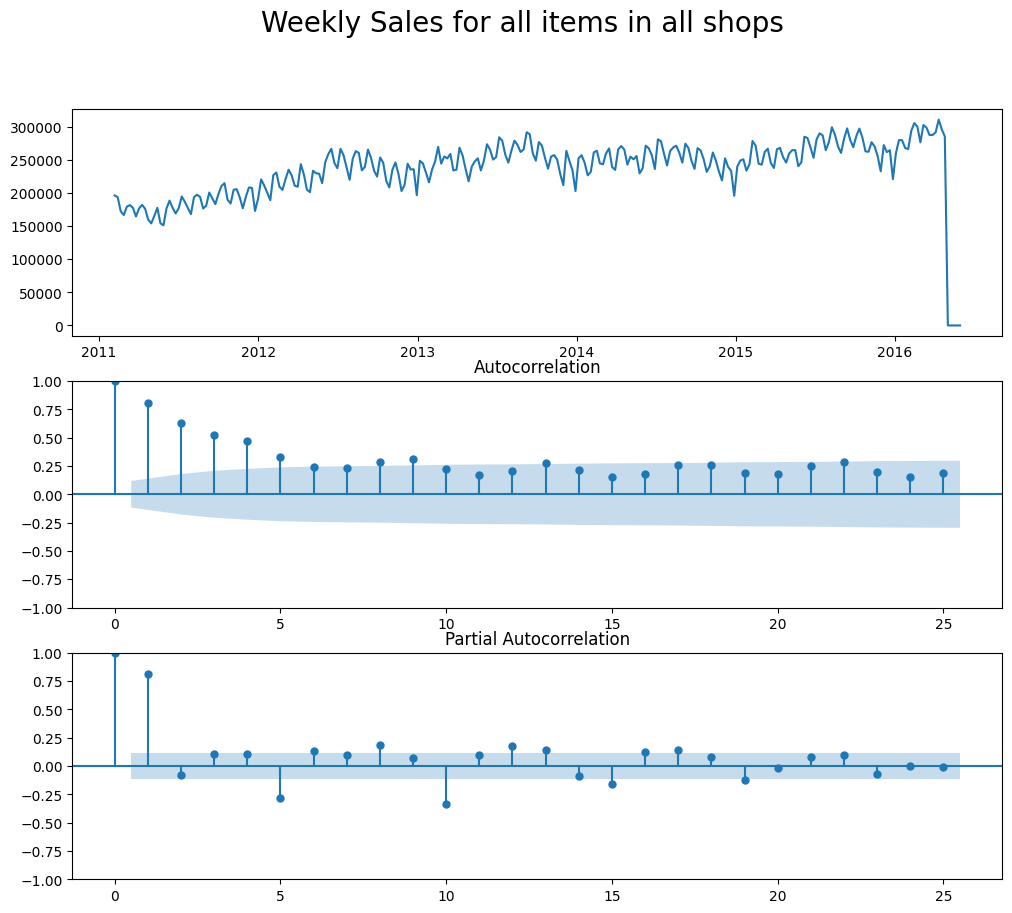

In [83]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

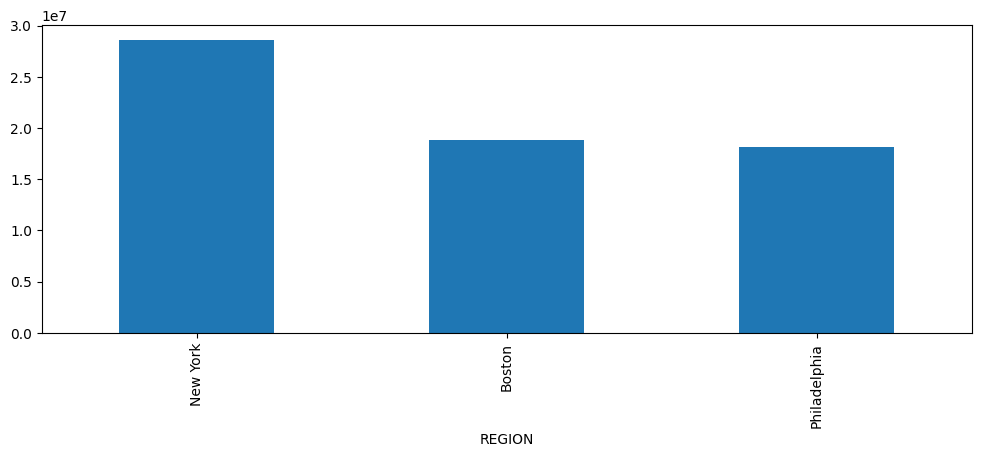

In [85]:
(
    full_df.
    groupby(["REGION"])
    ["WEEKLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

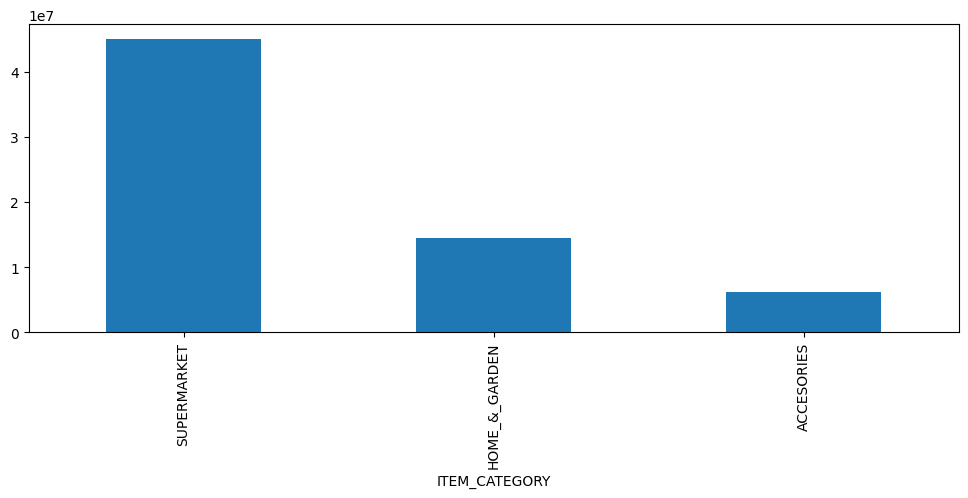

In [86]:
(
    full_df.
    groupby(["ITEM_CATEGORY"])
    ["WEEKLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

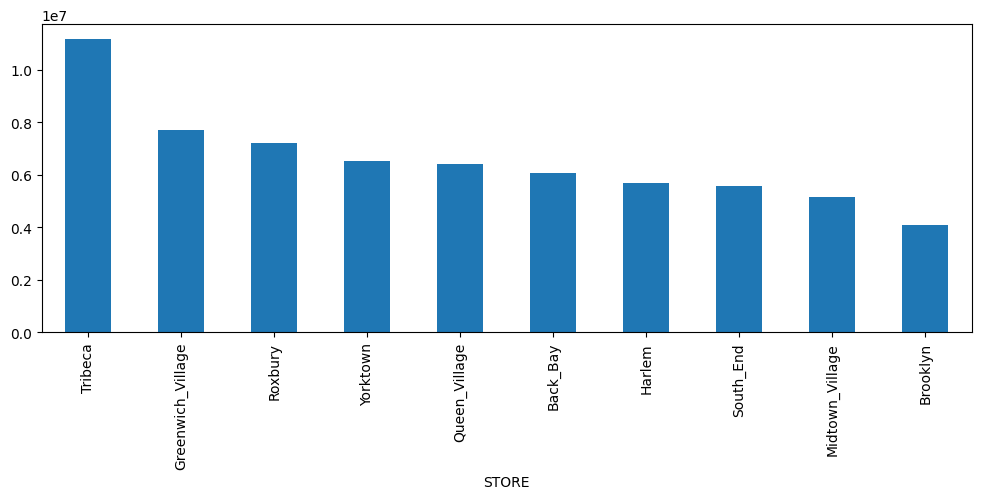

In [87]:
(
    full_df.
    groupby(["STORE"])
    ["WEEKLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [89]:
full_df.head()

,DATE,ID,WEEKLY_SALES,WEEKLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,WEEKLY_MEAN_PRICE,ITEM,ITEM_ID,ITEM_CATEGORY,ITEM_CATEGORY_ID,ITEM_DEPARTMENT,ITEM_DEPARTMENT_ID,STORE_CODE,REGION,REGION_ID,STORE,STORE_ID
0,2011-02-06,ACCESORIES_1_001_BOS_1,0.0,0.0,1.0,1.0,0.0,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,BOS_1,Boston,0.0,South_End,7.0
1,2011-02-06,ACCESORIES_1_001_BOS_2,0.0,0.0,1.0,1.0,0.0,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,BOS_2,Boston,0.0,Roxbury,6.0
2,2011-02-06,ACCESORIES_1_001_BOS_3,0.0,0.0,1.0,1.0,0.0,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,BOS_3,Boston,0.0,Back_Bay,0.0
3,2011-02-06,ACCESORIES_1_001_NYC_1,0.0,0.0,1.0,1.0,0.0,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,1.0,Greenwich_Village,2.0
4,2011-02-06,ACCESORIES_1_001_NYC_2,0.0,0.0,1.0,1.0,0.0,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_2,New York,1.0,Harlem,3.0


In [88]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8476220 entries, 0 to 8476219
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   DATE                    datetime64[ns]
 1   ID                      object        
 2   WEEKLY_SALES            float64       
 3   WEEKLY_REVENUE          float64       
 4   UNIQUE_DAYS_WITH_SALES  float64       
 5   TOTAL_TRANSACTIONS      float64       
 6   WEEKLY_MEAN_PRICE       float64       
 7   ITEM                    object        
 8   ITEM_ID                 float64       
 9   ITEM_CATEGORY           object        
 10  ITEM_CATEGORY_ID        float64       
 11  ITEM_DEPARTMENT         object        
 12  ITEM_DEPARTMENT_ID      float64       
 13  STORE_CODE              object        
 14  REGION                  object        
 15  REGION_ID               float64       
 16  STORE                   object        
 17  STORE_ID                float64       
dtypes:

In [96]:
COLUMNS_TO_DROP = [
    'UNIQUE_DAYS_WITH_SALES',
    'TOTAL_TRANSACTIONS',
    'ITEM',
    'ITEM_CATEGORY',
    'ITEM_DEPARTMENT',
    'REGION',
    'STORE',
]

full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

KeyError: "['UNIQUE_DAYS_WITH_SALES', 'TOTAL_TRANSACTIONS', 'ITEM', 'ITEM_CATEGORY', 'ITEM_DEPARTMENT', 'REGION', 'STORE'] not found in axis"

In [91]:
full_df.set_index("ID", inplace = True)

In [92]:
full_df.sample(5)

,DATE,WEEKLY_SALES,WEEKLY_REVENUE,WEEKLY_MEAN_PRICE,ITEM_ID,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,STORE_CODE,REGION_ID,STORE_ID
ID,,,,,,,,,,
ACCESORIES_1_012_NYC_4,2014-12-07,1.0,8.6716,8.6716,11.0,0.0,0.0,NYC_4,1.0,1.0
HOME_&_GARDEN_2_041_NYC_1,2015-07-19,3.0,18.6375,6.2125,1137.0,1.0,3.0,NYC_1,1.0,2.0
SUPERMARKET_2_259_BOS_1,2011-09-18,0.0,0.0000,0.0000,2085.0,2.0,5.0,BOS_1,0.0,7.0
HOME_&_GARDEN_1_159_BOS_3,2012-05-20,0.0,0.0000,0.0000,719.0,1.0,2.0,BOS_3,0.0,0.0
SUPERMARKET_2_139_PHI_1,2011-03-20,0.0,0.0000,0.0000,1965.0,2.0,5.0,PHI_1,2.0,4.0


In [97]:
full_df.drop('STORE_CODE', inplace = True, axis = 1)

In [98]:
full_df.sample(5)

,DATE,WEEKLY_SALES,WEEKLY_REVENUE,WEEKLY_MEAN_PRICE,ITEM_ID,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID
ID,,,,,,,,,
SUPERMARKET_3_263_BOS_3,2012-12-09,37.0,123.4320,3.3360,2487.0,2.0,6.0,0.0,0.0
HOME_&_GARDEN_2_492_PHI_2,2015-11-29,2.0,14.8000,7.4000,1587.0,1.0,3.0,2.0,9.0
ACCESORIES_2_042_NYC_4,2013-11-17,1.0,0.9842,0.9842,457.0,0.0,1.0,1.0,1.0
SUPERMARKET_2_159_BOS_1,2011-05-08,0.0,0.0000,0.0000,1985.0,2.0,5.0,0.0,7.0
ACCESORIES_2_018_BOS_1,2016-02-14,0.0,0.0000,4.4821,433.0,0.0,1.0,0.0,7.0


In [99]:
train_index = sorted(list(full_df["DATE"].unique()))[:-2]

valida_index = [sorted(list(full_df["DATE"].unique()))[-2]]

test_index = [sorted(list(full_df["DATE"].unique()))[-1]]

In [100]:
X_train = full_df[full_df["DATE"].isin(train_index)].drop(['WEEKLY_SALES', "DATE"], axis=1)
Y_train = full_df[full_df["DATE"].isin(train_index)]['WEEKLY_SALES']

X_valida = full_df[full_df["DATE"].isin(valida_index)].drop(['WEEKLY_SALES', "DATE"], axis=1)
Y_valida = full_df[full_df["DATE"].isin(valida_index)]['WEEKLY_SALES']

X_test = full_df[full_df["DATE"].isin(test_index)].drop(['WEEKLY_SALES', "DATE"], axis = 1)
Y_test = full_df[full_df["DATE"].isin(test_index)]['WEEKLY_SALES']

In [101]:
model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True)

[0]	validation_0-rmse:17.92004	validation_1-rmse:0.35624
[1]	validation_0-rmse:13.24136	validation_1-rmse:0.25561
[2]	validation_0-rmse:10.04179	validation_1-rmse:0.18173
[3]	validation_0-rmse:7.93514	validation_1-rmse:0.13339
[4]	validation_0-rmse:6.59914	validation_1-rmse:0.09618
[5]	validation_0-rmse:5.70563	validation_1-rmse:0.07163
[6]	validation_0-rmse:5.22562	validation_1-rmse:0.05445
[7]	validation_0-rmse:4.91098	validation_1-rmse:0.04410
[8]	validation_0-rmse:4.69118	validation_1-rmse:0.03385
[9]	validation_0-rmse:4.58727	validation_1-rmse:0.02979
[10]	validation_0-rmse:4.50935	validation_1-rmse:0.02595
[11]	validation_0-rmse:4.46631	validation_1-rmse:0.03083
[12]	validation_0-rmse:4.42517	validation_1-rmse:0.03263
[13]	validation_0-rmse:4.37971	validation_1-rmse:0.03084
[14]	validation_0-rmse:4.34295	validation_1-rmse:0.02692
[15]	validation_0-rmse:4.28278	validation_1-rmse:0.02425
[16]	validation_0-rmse:4.24553	validation_1-rmse:0.02480
[17]	validation_0-rmse:4.15428	validat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [102]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2023_05_07_23_25_34.dat


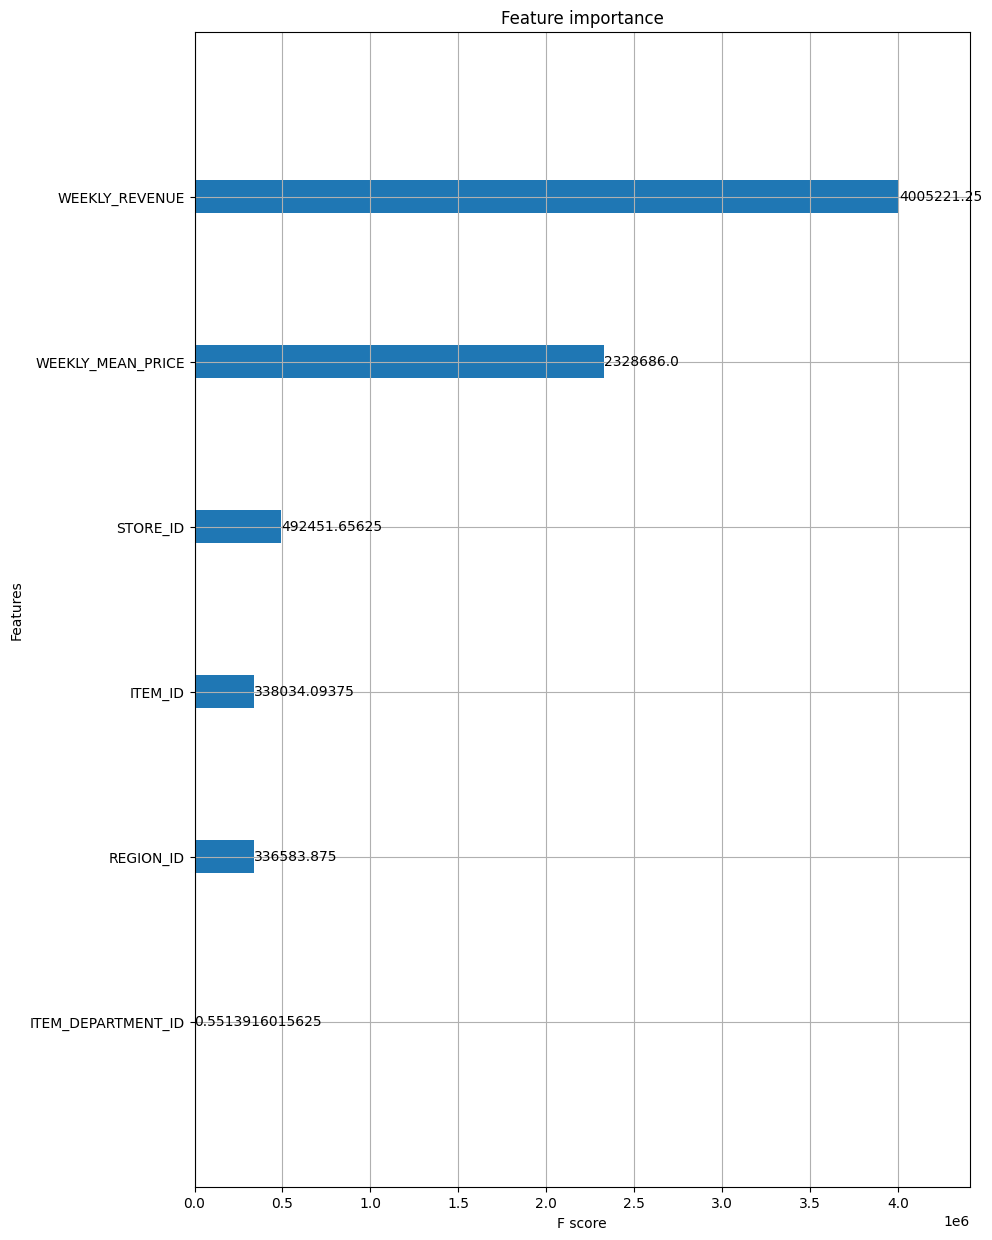

In [103]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

In [1]:
last_trained_model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

NameError: name 'pickle' is not defined